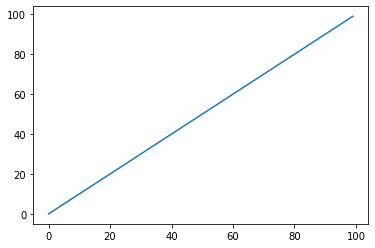

In [1]:
##Used to initialise MATPLOTLIB in Jupyter with PyTorch

import matplotlib.pyplot as plt

plt.plot(range(0,100,1))

In [2]:
import torch
from PIL import Image
from collections import namedtuple
from torchvision import models
 
import argparse
import os
import sys
import time
import re
from itertools import chain
 
import numpy as np
import pandas as pd

from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.onnx
from torch import nn
import torch.nn.functional as F
from torch import optim

In [3]:
def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img


def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div(255.0)
    return (batch - mean) / std

In [4]:
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True).features

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        for x in range(9):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 25):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        feature_conv2 = h
        h = self.slice2(h)
        feature_conv3 = h
        h = self.slice3(h)
        feature_conv4 = h
        vgg_outputs = namedtuple("VggOutputs", ['conv2', 'conv3', 'conv4'])
        out = vgg_outputs(feature_conv2, feature_conv3, feature_conv4)
        return out

In [5]:
def weight_init(network):
    ### Initialise weights as Isotropic Gaussian
    for module in network.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, mean = 0, std = 0.01)
                nn.init.normal_(module.bias, mean = 0, std = 0.01)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean = 0, std = 0.01)
                nn.init.normal_(module.bias, mean = 0, std = 0.01)

class ConditionerNet(nn.Module):
    def __init__(self, n_outputs=4230, n_inputs=3):
        "3 input channels- alpha_s1, alpha_s2, alpha_s3"
        "need to output gamma and beta for feature map in T network"

        super(ConditionerNet, self).__init__()
        self.dense_input = nn.Sequential(nn.Linear(n_inputs, 1000), nn.ReLU())
        self.dense1 = nn.Sequential(nn.Linear(1000, 1000), nn.ReLU())
        self.dense2 = nn.Sequential(nn.Linear(1000, 1000), nn.ReLU())
        self.dense3 = nn.Sequential(nn.Linear(1000, 1000), nn.ReLU())
        self.dense4 = nn.Sequential(nn.Linear(1000, 1000), nn.ReLU())
        self.dense_out = nn.Linear(1000, n_outputs)
    
    def forward(self, alpha):
        out = self.dense_input(alpha)
        out = self.dense1(out)
        out = self.dense2(out)
        out = self.dense3(out)
        out = self.dense4(out)
        out = self.dense_out(out)  
        return out # Returns the Conditional Instance Params


class TransformerNet(torch.nn.Module):
    # Utilise GitHub implementation with added instance normal
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.conv1 = ConvLayer(3, 32, kernel_size = 9, stride = 1) 
        self.in1 = ContitionalInstanceNorm2d()

        self.conv2 = ConvLayer(32, 64, kernel_size = 3, stride = 2)
        self.in2 = ContitionalInstanceNorm2d()

        self.conv3 = ConvLayer(64, 128, kernel_size = 3, stride = 2)
        self.in3 = ContitionalInstanceNorm2d()

        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        self.res6 = ResidualBlock(128)
        self.res7 = ResidualBlock(128)

        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size = 3, stride = 1, upsample = 2)
        self.in4 = ContitionalInstanceNorm2d()
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size = 3, stride = 1, upsample = 2)
        self.in5 = ContitionalInstanceNorm2d()
        self.deconv3 = ConvLayer(32, 3, kernel_size = 9, stride = 1)
        self.relu = torch.nn.ReLU()
        self.in6 = ContitionalInstanceNorm2d()
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, X, gammas, betas):
        y = self.relu(self.in1(self.conv1(X), gammas[:,0:32,:,:], betas[:,0:32,:,:]))
        y = self.relu(self.in2(self.conv2(y), gammas[:,32:96,:,:], betas[:,32:96,:,:]))
        y = self.relu(self.in3(self.conv3(y), gammas[:,96:224,:,:], betas[:,96:224,:,:]))
        y = self.res1(y, gammas[:,224:480,:,:], betas[:,224:480,:,:])
        y = self.res2(y, gammas[:,480:736,:,:], betas[:,480:736,:,:])
        y = self.res3(y, gammas[:,736:992,:,:], betas[:,736:992,:,:])
        y = self.res4(y, gammas[:,992:1248,:,:], betas[:,992:1248,:,:])
        y = self.res5(y, gammas[:,1248:1504,:,:], betas[:,1248:1504,:,:])
        y = self.res6(y, gammas[:,1600:1856,:,:], betas[:,1600:1856,:,:])
        y = self.res7(y, gammas[:,1856:2112,:,:], betas[:,1856:2112,:,:])
        y = self.relu(self.in4(self.deconv1(y), gammas[:,1504:1568,:,:], betas[:,1504:1568,:,:]))
        y = self.relu(self.in5(self.deconv2(y), gammas[:,1568:1600,:,:], betas[:,1568:1600,:,:]))
        y = (self.in6(self.deconv3(y), gammas[:,2112:2115,:,:], betas[:,2112:2115,:,:]))
        ## Cause of very slow and unsteady learning if sigmoid!
        y = self.relu(y)
        return y

class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels=128):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = ContitionalInstanceNorm2d()
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = ContitionalInstanceNorm2d()
        self.relu = torch.nn.ReLU()

    def forward(self, x, gammas, betas):
        residual = x
        out = self.relu(self.in1(self.conv1(x), gammas[:,0:self.channels,:,:], betas[:,0:self.channels,:,:]))
        out = self.in2(self.conv2(out), gammas[:,self.channels:self.channels * 2,:,:], betas[:,self.channels:self.channels * 2,:,:])
        out = out + residual # need relu right after
        return out
    
class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

class ContitionalInstanceNorm2d(torch.nn.Module):
    def __init__(self):
        super(ContitionalInstanceNorm2d, self).__init__()
    
    def forward(self, x, gammas, betas):
        std = x.std(dim = [2, 3], keepdim=True) # computes standard deviation of each filter
        mean = x.mean(dim = [2, 3], keepdim=True) # computes mean of each filter
        l = (x - mean) / std # filter output is zero mean and unit variance
        return l*gammas + betas # applying reparameterisation trick

In [6]:
def check_paths(args):
    try:
        if not os.path.exists(args.save_model_dir):
            os.makedirs(args.save_model_dir)
        if args.checkpoint_model_dir is not None and not (os.path.exists(args.checkpoint_model_dir)):
            os.makedirs(args.checkpoint_model_dir)
    except OSError as e:
        print(e)
        sys.exit(1)

def load_weights(model, conditioner, transformer):
    if model is not None:
        state_dict = torch.load(model)
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        transformer.load_state_dict(state_dict)

        csd = torch.load(model+'.cond.pth')
        conditioner.load_state_dict(csd)        


def train(train_dataset_dir, style_image, style_size=None, image_size=256, learning_rate=1e-3, epochs=2, batch_size=8, content_weight=1e5
          , style_weight=1e10, log_interval=500, checkpoint_interval=2000, seed=0, checkpoint_model_dir="./Checkpoints/"
          , cuda=False, save_model_dir="./Complete Models/", model=None):
    device = torch.device("cuda:1" if cuda else "cpu")
    
    loss_emas = []
    loss_contents = []
    total_losses = []
    
    print("Device: " + str(device))

    np.random.seed(seed)
    torch.manual_seed(seed)

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(train_dataset_dir, transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    conditioner = ConditionerNet().to(device)
    transformer = TransformerNet().to(device)
    conditioner.apply(weight_init)
    transformer.apply(weight_init)
    
    load_weights(model, conditioner, transformer)
    optimizer = Adam(chain(transformer.parameters(), conditioner.parameters()), learning_rate)
    mse_loss = torch.nn.MSELoss(reduction='mean')
    frob_norm = torch.norm

    vgg = Vgg19(requires_grad=False).to(device)
    style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    style = load_image(style_image, size=style_size)
    style = style_transform(style)
    style = style.repeat(batch_size, 1, 1, 1).to(device)

    features_style = vgg(normalize_batch(style))
    gram_style = [gram_matrix(y) for y in features_style]
    loss_ema = torch.ones(4).to(device)
    layer_loss = torch.ones(4).to(device)
    ema_alpha = 0.01

    for e in range(epochs):
        print("Epoch: " + str(e))
        if(e > 0):
            print("Agg. Content Loss: " + str(agg_content_loss))
            print("Agg. Style Loss: " + str(agg_style_loss))
        transformer.train()
        conditioner.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            if(batch_id % 100 == 0):
                print("Batch: " + str(batch_id))
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)

            if (torch.rand(1).item() > 0.5):
                stylization_vector = torch.rand(3).to(device)
            else:
                stylization_vector = torch.zeros(3).to(device)
                stylization_vector[batch_id % 3] = 1

            style_input = torch.ones(n_batch, 3).to(device) * stylization_vector.unsqueeze(0)
            c_values = conditioner(torch.ones(n_batch, 3).to(device) * stylization_vector.unsqueeze(0)).unsqueeze(2).unsqueeze(2)
            

            gammas = c_values[:, 0:2115, :, :]
            betas = c_values[:, 2115:4230, :, :]

            y = transformer(x, gammas, betas)

            y = normalize_batch(y)
            x = normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = mse_loss(features_y.conv3, features_x.conv3)
            
            layers_losses = torch.ones(4).to(device)
            layers_losses[0] = content_loss
            layer_loss[0] = content_loss.detach()

            style_loss = 0.
            for i, (ft_y, gm_s) in enumerate(zip(features_y, gram_style)):
                gm_y = gram_matrix(ft_y)
                ll = torch.mean(torch.square(frob_norm((gm_y - gm_s[:n_batch, :, :]), dim=(1,2))))
                layers_losses[i+1] = ll
                layer_loss[i+1] = ll.detach()
            
            if(batch_id == 0):
                loss_ema = layer_loss
            
            for i, (ft_y, gm_s) in enumerate(zip(features_y, gram_style)):
                style_loss = style_loss + (loss_ema[1:4].sum() / loss_ema[i+1]) * layers_losses[i+1] * stylization_vector[i]
            
            content_loss = layers_losses[0]
            
            loss_ema = ema_alpha * layer_loss + (1 - ema_alpha) * loss_ema

            total_loss = content_loss + style_loss
            if(batch_id % 100 == 0):
                print("Total Loss (Post EMA): " + str(total_loss))
                print("Style Loss (Post EMA): " + str(style_loss))
                print("Style Loss (ema): SUM(" + str(loss_ema[1].item()) + "," + str(loss_ema[2].item()) + "," + str(loss_ema[3].item()) + ")")
                print("Content Loss (Post EMA): " + str(content_loss))
                print("Content Loss (ema): " + str(loss_ema[0].item()))
            total_loss.backward()
            optimizer.step()
            
            loss_emas.append(loss_ema[1:4].sum().item())
            loss_contents.append(loss_ema[0].item())
            total_losses.append(loss_ema.sum().item())
            

            agg_content_loss += content_loss.item()
            agg_style_loss += loss_ema.sum()

            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

            if checkpoint_model_dir is not None and (batch_id + 1) % checkpoint_interval == 0:
                transformer.eval().cpu()
                conditioner.eval().cpu()
                ckpt_model_filename = "ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1) + ".pth"
                ckpt_model_path = os.path.join(checkpoint_model_dir, ckpt_model_filename)
                torch.save(transformer.state_dict(), ckpt_model_path)
                torch.save(conditioner.state_dict(), ckpt_model_path+'.cond.pth')
                transformer.to(device).train()
                conditioner.to(device).train()
                
                ckpt_loss_filename = "./Loss Plots/ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1)
                
                losses = pd.Series(loss_emas, index=range(len(loss_emas)))
                style_stds = losses.rolling(80).std()
                style_means = losses.rolling(80).mean()
                plt.plot(losses.index, losses, 'b')
                plt.plot(style_stds.index, style_means+style_stds, 'r')
                plt.plot(style_stds.index, style_means-style_stds, 'r')
                plt.plot(style_means.index, style_means, 'k')
                plt.title("Style Loss")
                plt.yscale("log")
                plt.ylabel("$Log_{10}(Loss)$")
                plt.xlabel("Batch Number")
                plt.savefig(ckpt_loss_filename + "_style.png", format="png")
                plt.clf()
                
                losses = pd.Series(loss_emas, index=range(len(loss_emas)))[-10000:]
                style_stds = losses.rolling(80).std()
                style_means = losses.rolling(80).mean()
                plt.plot(losses.index, losses, 'b')
                plt.plot(style_stds.index, style_means+style_stds, 'r')
                plt.plot(style_stds.index, style_means-style_stds, 'r')
                plt.plot(style_means.index, style_means, 'k')
                plt.title("Style Loss")
                plt.yscale("linear")
                plt.ylabel("Loss")
                plt.xlabel("Batch Number")
                plt.savefig(ckpt_loss_filename + "_style_linear.png", format="png")
                plt.clf()
                
                losses = pd.Series(loss_contents, index=range(len(loss_emas)))
                stds = losses.rolling(80).std()
                means = losses.rolling(80).mean()
                plt.plot(losses.index, losses, 'b')
                plt.plot(stds.index, means+stds, 'r')
                plt.plot(stds.index, means-stds, 'r')
                plt.plot(means.index, means, 'k')
                plt.title("Content Loss")
                plt.yscale("log")
                plt.ylabel("$Log_{10}(Loss)$")
                plt.xlabel("Batch Number")
                plt.savefig(ckpt_loss_filename + "_content.png", format="png")
                plt.clf()
                
                losses = pd.Series(loss_contents, index=range(len(loss_emas)))[-10000:]
                stds = losses.rolling(80).std()
                means = losses.rolling(80).mean()
                plt.plot(losses.index, losses, 'b')
                plt.plot(stds.index, means+stds, 'r')
                plt.plot(stds.index, means-stds, 'r')
                plt.plot(means.index, means, 'k')
                plt.title("Content Loss")
                plt.yscale("linear")
                plt.ylabel("Loss")
                plt.xlabel("Batch Number")
                plt.savefig(ckpt_loss_filename + "_content_linear.png", format="png")
                plt.clf()
                
                losses = pd.Series(total_losses, index=range(len(loss_emas)))
                stds = losses.rolling(80).std()
                means = losses.rolling(80).mean()
                plt.plot(losses.index, losses, 'b')
                plt.plot(stds.index, means+stds, 'r')
                plt.plot(stds.index, means-stds, 'r')
                plt.plot(means.index, means, 'k')
                plt.title("Total Loss")
                plt.yscale("log")
                plt.ylabel("$Log_{10}(Loss)$")
                plt.xlabel("Batch Number")
                plt.savefig(ckpt_loss_filename + "_total.png", format="png")
                plt.clf()

                losses = pd.Series(total_losses, index=range(len(loss_emas)))[-10000:]
                stds = losses.rolling(80).std()
                means = losses.rolling(80).mean()
                plt.plot(losses.index, losses, 'b')
                plt.plot(stds.index, means+stds, 'r')
                plt.plot(stds.index, means-stds, 'r')
                plt.plot(means.index, means, 'k')
                plt.title("Total Loss")
                plt.yscale("linear")
                plt.ylabel("Loss")
                plt.xlabel("Batch Number")
                plt.savefig(ckpt_loss_filename + "_total_linear.png", format="png")
                plt.clf()

    # save model
    transformer.eval().cpu()
    save_model_filename = "epoch_" + str(epochs) + "_" + str(time.ctime()).replace(' ', '_').replace(':', '_') + "_" + str(
        content_weight) + "_" + str(style_weight) + ".model"
    save_model_path = os.path.join(save_model_dir, save_model_filename)
    torch.save(conditioner.state_dict(), save_model_path+'.cond.pth')
    torch.save(transformer.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)
    return save_model_path


def stylize(content_image, output_image_path, model_path, content_scale=None, animate=0, export_onnx_path=False, cuda=False, style=False):
    device = torch.device("cuda" if cuda else "cpu")
    print(device)

    content_image = load_image(content_image, scale=content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    if model_path.endswith(".onnx"):
        output = stylize_onnx_caffe2(content_image, export_onnx_path, model_path, cuda)
    else:
        with torch.no_grad():
            style_model = TransformerNet()
            state_dict = torch.load(model_path)
            # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
            for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
            style_model.load_state_dict(state_dict)
            style_model.to(device)

            conditioner = ConditionerNet()
            csd = torch.load(model_path+'.cond.pth', map_location=torch.device('cpu'))
            conditioner.load_state_dict(csd)
            conditioner.to(device)

            if export_onnx_path:
                assert export_onnx_path.endswith(".onnx"), "Export model file should end with .onnx"
                output = torch.onnx._export(style_model, content_image, export_onnx_path).cpu()
            else:
                if animate:
                    keypoints = [
                        torch.tensor([0., 0., 0.]),
                        torch.tensor([1., 0., 0.]),
                        torch.tensor([0., 1., 0.]),
                        torch.tensor([0., 0., 1.]),
                        torch.tensor([1., 0., 1.]),
                        torch.tensor([1., 1., 1.]),
                    ]

                    for frame in range(0, 100):
                        start = frame // 20
                        end = start + 1

                        stylization_vector = keypoints[start].lerp(keypoints[end], (frame % 20) / 20).to(device)

                        c_values = conditioner(
                            stylization_vector.unsqueeze(0)).unsqueeze(2).unsqueeze(2)

                        gammas = c_values[:, 0:2115, :, :]
                        betas = c_values[:, 2115:4230, :, :]  

                        output = style_model(content_image, gammas, betas).cpu()
                        save_image(output_image_path + "." + str(frame) + ".jpg", output[0])
                else:
                    if(not style):
                        stylization_vector = torch.tensor([0.,0.,0.]).to(device)
                    else:
                        stylization_vector = torch.tensor([1.,1.,1.]).to(device)

                    c_values = conditioner(stylization_vector.unsqueeze(0)).unsqueeze(2).unsqueeze(2)

                    gammas = c_values[:, 0:2115, :, :]
                    betas = c_values[:, 2115:4230, :, :]  

                    output = style_model(content_image, gammas, betas).cpu()
    save_image(output_image_path, output[0])


def stylize_onnx_caffe2(content_image, export_onnx, model_path, cuda):
    """
    Read ONNX model and run it using Caffe2
    """

    assert not export_onnx

    import onnx
    import onnx_caffe2.backend

    model = onnx.load(model_path)

    prepared_backend = onnx_caffe2.backend.prepare(model, device='CUDA' if cuda else 'CPU')
    inp = {model.graph.input[0].name: content_image.numpy()}
    c2_out = prepared_backend.run(inp)[0]

    return torch.from_numpy(c2_out)

In [ ]:
torch.autograd.set_detect_anomaly(True)

#model_final_path = train("../../../../data/ILSVRC2012/train", "./Style Images/Swirly2.jpg", epochs=2, cuda=True, checkpoint_interval=800, log_interval=100)
model_final_path = train("./Cavaliers/", "./Spiral.jpg", epochs=2, cuda=False, checkpoint_interval=2000, batch_size=4)

In [14]:
stylize("./n02098286_6245.JPEG", "./Output/output_style.jpg", "./saved_models/Simple Model/ckpt_epoch_0_batch_id_500.pth", animate=0, style=True)
stylize("./n02098286_6245.JPEG", "./Output/output_content.jpg", "./saved_models/Simple Model/ckpt_epoch_0_batch_id_500.pth", animate=0, style=False)

cpu
cpu


In [11]:
import seaborn as sn

def create_layer_loss_plots(content_image, model_path, content_scale=None, cuda=False, style_image="./Swirly2.jpg", grain=0.1):
    device = torch.device("cuda" if cuda else "cpu")
    print(device)

    content_image = load_image(content_image, scale=content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():

        #Load Networks
        style_model = TransformerNet()
        state_dict = torch.load(model_path)
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        style_model.load_state_dict(state_dict)
        style_model.to(device)

        conditioner = ConditionerNet()
        csd = torch.load(model_path+'.cond.pth', map_location=torch.device('cpu'))
        conditioner.load_state_dict(csd)
        conditioner.to(device)
        
        frob_norm = torch.norm

        vgg = Vgg19(requires_grad=False).to(device)
        
        style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
        ])
        style = load_image(style_image, size=None)
        style = style_transform(style)
        style = style.repeat(1, 1, 1, 1).to(device)

        features_style = vgg(normalize_batch(style))
        gram_style = [gram_matrix(y) for y in features_style]

        layer_losses = np.zeros((2, 3, len(np.arange(0, 1.1, grain))))
        for others in range(2):
            for i in range(3):
                for val in np.arange(0, 1.1, grain):
                    if(others == 0):
                        stylization_vector = torch.zeros(3)
                    else:
                        stylization_vector = torch.ones(3)

                    stylization_vector[i] = val


                    c_values = conditioner(stylization_vector.unsqueeze(0)).unsqueeze(2).unsqueeze(2)

                    gammas = c_values[:, 0:2115, :, :]
                    betas = c_values[:, 2115:4230, :, :]

                    y = style_model(content_image, gammas, betas)
                    x = content_image

                    y = normalize_batch(y)
                    x = normalize_batch(x)

                    features_y = vgg(y)
                    features_x = vgg(x)

                    style_loss = 0.
                    for j, (ft_y, gm_s) in enumerate(zip(features_y, gram_style)):
                        if(j == i):
                            gm_y = gram_matrix(ft_y)
                            ll = torch.mean(torch.square(frob_norm((gm_y - gm_s[:, :, :]), dim=(1,2)))) #* style_weight
                            layer_losses[others][i][int(val/grain)] = ll.detach()

        zero_losses = layer_losses[0]
        one_losses = layer_losses[1]

        plt.rcParams["figure.figsize"] = (3.3,3)
        colours = ['b','g','r']

        for i in range(3):
            losses = zero_losses[i]
            losses -= np.min(np.abs(losses))
            losses /= np.max(np.abs(losses))
            sn.lineplot(x = np.arange(0, 1.1, grain), y = losses, label=("Conv" + str(i+2)), color=colours[i], marker='o')
        plt.xlabel("Input Parameter Value")
        plt.ylabel("Normalised Style Loss")
        plt.show()

        for i in range(3):
            losses = one_losses[i]
            losses -= np.min(np.abs(losses))
            losses /= np.max(np.abs(losses))
            sn.lineplot(x = np.arange(0, 1.1, grain), y = losses, label=("Conv" + str(i+2)), color=colours[i], marker='o')
        plt.xlabel("Input Parameter Value")
        plt.ylabel("Normalised Style Loss")
        plt.show()
        
        plt.rcParams["figure.figsize"] = (10,8)
        
        return (zero_losses, one_losses)

cpu
Starting Others = 0
Starting Layer = 0
Starting Value = 0.0
Starting Value = 0.1
Starting Value = 0.2
Starting Value = 0.30000000000000004
Starting Value = 0.4
Starting Value = 0.5
Starting Value = 0.6000000000000001
Starting Value = 0.7000000000000001
Starting Value = 0.8
Starting Value = 0.9
Starting Value = 1.0
Starting Layer = 1
Starting Value = 0.0
Starting Value = 0.1
Starting Value = 0.2
Starting Value = 0.30000000000000004
Starting Value = 0.4
Starting Value = 0.5
Starting Value = 0.6000000000000001
Starting Value = 0.7000000000000001
Starting Value = 0.8
Starting Value = 0.9
Starting Value = 1.0
Starting Layer = 2
Starting Value = 0.0
Starting Value = 0.1
Starting Value = 0.2
Starting Value = 0.30000000000000004
Starting Value = 0.4
Starting Value = 0.5
Starting Value = 0.6000000000000001
Starting Value = 0.7000000000000001
Starting Value = 0.8
Starting Value = 0.9
Starting Value = 1.0
Starting Others = 1
Starting Layer = 0
Starting Value = 0.0
Starting Value = 0.1
Startin

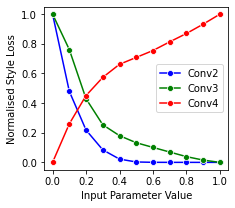

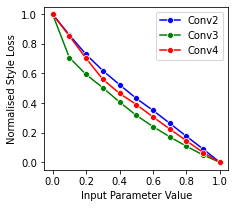

In [10]:
(zero_losses, one_losses) = create_layer_loss_plots("./n02098286_6245.JPEG", "./saved_models/Simple Model/ckpt_epoch_0_batch_id_1500.pth", grain=0.1)